# ML Final Project

## Import Packages

In [168]:
# Import required packages
from datetime import datetime,date
import numpy as np
import calendar
from dateutil import parser
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.warp import reproject, Resampling
from shapely.geometry import box
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, Dense, LSTM, RepeatVector, TimeDistributed, Input, Reshape, BatchNormalization
from tensorflow.keras.models import Sequential, Model

from keras.callbacks import EarlyStopping
import pickle

import tensorflow as tf #version 2.11.0
import keras #v 2.11.0
import os

# import rasterio
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform#, reproject

import json

from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.callbacks import LearningRateScheduler


      
np.random.seed(5)



## Load .npy data stacks

In [271]:
os.chdir('/Users/clairesimpson/Desktop/CU/LSTM_Project/Output_Data/Data_2024_05_32')

X_train=np.load("X_train.npy")
X_val=np.load("X_val.npy")
X_test=np.load( "X_test.npy")
y_train=np.load("y_train.npy")
y_val=np.load("y_val.npy")
y_test=np.load("y_test.npy")
y_train1=np.load("y_train1.npy" )
y_train2=np.load("y_train2.npy" )
y_test1=np.load("y_test1.npy")
y_test2=np.load("y_test2.npy")
y_val1=np.load("y_val1.npy")
y_val2=np.load("y_val2.npy") #note: saving stdardized data so will need ot unstd. to get back to real val range


#read in list of fire IDs to associate metrics w
x_test_df_storeIDs_csv = pd.read_csv("x_test_df_storeIDs.csv")
x_test_df_storeIDs = x_test_df_storeIDs_csv["0"].values.tolist()


SyntaxError: invalid syntax (1254236443.py, line 1)

## Tune Hyperparameters for LSTM using Hyperband

In [ ]:
# # build a class that inherits from HyperModel
# class RegressionHyperModel(HyperModel):

#     def __init__(self, timesteps, num_vars, num_outsteps):
#         self.input_shape = (timesteps, num_vars)
#         self.num_outsteps = num_outsteps
#         # input_shape = 45#(timesteps, num_vars)

#     def build(self, hp): # define the structure of the network and the searchable space for each param

#         model = Sequential()
#         #Design a hyper parameter space
#         #For activation, ONLY try tanh. No need to search for relu.
#         model.add(
#             LSTM( # add a dense layer
#                 units=hp.Int('units', 10, 20, 50, default=20), # number of nodes: values from 8 to 64 in multiples of 4, and a default value of 8
#                 # activation='tanh',
#                 # activation=hp.Choice(
#                 #       'lstm_activation',
#                 #     values=['tanh'], # different activation functions to test
#                 #     default='tanh'),
#                 input_shape = self.input_shape)
#             )

#         model.add(RepeatVector(num_outsteps))


#         # model.add( # add dropout with values from 0.0 to 0.3 with increments of 0.1
#         #     Dropout(
#         #         rate = hp.Float(
#         #             'dropout',
#         #             min_value=0.0, #try out different dropout percentages from 0 to 30 percent of the nuorons in this layer.
#         #             max_value=0.3,
#         #             default=0.005,
#         #             step=0.1)
#         #     )
#         # )
#         model.add(
#             LSTM( # add a second dense layer
#                 units=hp.Int('units', 10, 20, 50, default=20),
#                 # activation=hp.Choice(
#                 #     'lstm_activation',
#                 #     values=['tanh'],
#                 #     default='tanh'),
#                  return_sequences=True
#             ),


#             )
#         model.add(TimeDistributed(Dense(1)))

#         #Compile
#         model.compile(
#             optimizer=keras.optimizers.Adam(
#                 hp.Choice('learning_rate',
#                           values=[1e-2, 1e-3])), #Took  1e-4 out to run faster in class.
#                       loss='mse',
#                       metrics=['mse'])
#         return model

In [ ]:
# # build a class that inherits from HyperModel
# class StackedLSTMHyperModel(HyperModel):

#     def __init__(self, timesteps, num_vars, num_outsteps):
#         self.input_shape = (timesteps, num_vars)
#         self.num_outsteps = num_outsteps
#         # input_shape = 45#(timesteps, num_vars)

#     def build(self, hp): # define the structure of the network and the searchable space for each param

#         model = Sequential()
#         #Design a hyper parameter space
#         #For activation, ONLY try tanh. No need to search for relu.
#         model.add(
#             LSTM(units=hp.Int('units', min_value=10, max_value=600, step=20), # number of nodes: values from 8 to 64 in multiples of 4, and a default value of 8
#                 # will test units = 10, 30,50
#                 # activation=hp.Choice(
#                 #       'lstm_activation',
#                 #     values=['tanh'], # different activation functions to test
#                 #     default='tanh'),
#                 return_sequences = True,
#                 input_shape = self.input_shape),
#             )
#         # model.add( # add dropout with values from 0.0 to 0.3 with increments of 0.1
#         #     Dropout(
#         #         rate = hp.Float(
#         #             'dropout',
#         #             min_value=0.0, #try out different dropout percentages from 0 to 30 percent of the nuorons in this layer.
#         #             max_value=0.3,
#         #             default=0.005,
#         #             step=0.1)
#         #     )
#         # )
#         model.add(LSTM(units=hp.Int('units', min_value=10, max_value=600, step=20), return_sequences=False),)
#         model.add(Dense(num_outsteps))

#         #Compile
#         model.compile(
#             optimizer=keras.optimizers.Adam(
#                 hp.Choice('learning_rate',
#                           values=[1e-2, 1e-3])), #Took  1e-4 out to run faster in class.
#                       loss='mse',
#                       metrics=['mse'])
#         return model

In [ ]:
timesteps = prefire_mo #how many years pre-fire are predictors?
num_vars = 11 #number of features: precip, temp, ndvi, elev, slope, aspect, mtpi, chili, LAI (added! 7/19/23)
# units = 50 #units in lstm layer
num_outsteps = y_test.shape[1] #how many timesteps to predict [post-fire]

# hypermodel = RegressionHyperModel(timesteps,num_vars, num_outsteps)
# stacked_hypermodel = StackedLSTMHyperModel(timesteps, num_vars, num_outsteps)

In [ ]:
# this is defined to clear training output after each run of hyperparam tuning
import IPython
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

## Fit/tune model to data
NOTE:hyperband tuner does not work...


In [ ]:
# #Perform the search to tune tuner_hb using training data. This will take ~10-20 mins to run.
# early_stops = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
# copy_hb=0
# if tune_hyperparameters == 'encoder-decoder':
#   '''
#   create hyperband tuner using the hypermodel that is created above and with
#   the following values
#   '''
#   # Hyperband optimization
#   tuner_hb = Hyperband(hypermodel, objective='val_mse',factor=4, max_epochs=300,
#                      hyperband_iterations=2,seed=5,overwrite=True)
#   tuner_hb.search(X_train, y_train, batch_size = 64, validation_data = (X_val, y_val),
#                   verbose=1, callbacks=[early_stops])#, ClearTrainingOutput()])
# elif tune_hyperparameters == 'stacked':
#   tuner_hb = Hyperband(stacked_hypermodel, objective='val_mse',factor=4, max_epochs=300,
#                      hyperband_iterations=2,seed=5,overwrite=True)
#   tuner_hb.search(X_train, y_train, batch_size = 64, validation_data = (X_val, y_val),
#                   verbose=1, callbacks=[early_stops])#, ClearTrainingOutput()])

#   copy_hb=tuner_hb

In [ ]:
# if tune_hyperparameters is not False:
#   best_model_hb = tuner_hb.get_best_models(num_models=1)[0]
#   print("Eval:",best_model_hb.evaluate(X_test, y_test))

#   # tuned_model = tuner_hb.get_best_models(1)[0]
#   tuned_model_params = best_model_hb.get_config()

#   best_hps0 = tuner_hb.get_best_hyperparameters(num_trials = 1)[0]
#   print("Best learning rate:",best_hps0.get('learning_rate'))

#   for i in range(0, len(tuned_model_params['layers'])-1):
#     print('layer number: {}'.format(i))
#     if tune_hyperparameters=='encoder-decoder':
#       if i%2 == 0:
#         pass
#         #non-LSTM
#         # print('layer name: {}'.format(tuned_model_params['layers'][i]['config']['name']), ', dropout rate: {}'.format(tuned_model_params['layers'][i]['config']['rate']))
#       else:
#         #LSTM
#         print('layer name: {}'.format(tuned_model_params['layers'][i]['config']['name']), ', activation: {}'.format(tuned_model_params['layers'][i]['config']['activation']), ', number of nodes: {}'.format(tuned_model_params['layers'][i]['config']['units']))
#         # nodes_layer2 = tuned_model_params['layers'][i]['config']['units']
#       print('---------------------------------------')
#     else:
#       try:
#         print('layer name: {}'.format(tuned_model_params['layers'][i]['config']['name']), ', activation: {}'.format(tuned_model_params['layers'][i]['config']['activation']), ', number of nodes: {}'.format(tuned_model_params['layers'][i]['config']['units']))
#       except:
#         pass


## Build LSTM using best hyperparameters

### StackedLSTM for Multihead model (to predict LAI and NDVI + VCF Tree %)

In [ ]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Reshape

# # Input data shape
# timesteps_input = prefire_mo# same as timesteps
# num_vars = 11 #+1 bc added vcf tree pct as predictor (as well as target)

# # Output data shape
# timesteps_output = 98
# num_targets = 2  # Number of targets to predict (NDVI and LAI) --> change to 3 if using VCF

# units = 100

# # Define the input layer
# input_layer = Input(shape=(timesteps_input, num_vars))

# # LSTM layers shared across both heads
# lstm_layer1 = LSTM(units, activation='tanh', return_sequences=True)(input_layer)
# dropout_layer1 = Dropout(0.1)(lstm_layer1)

# lstm_layer2 = LSTM(units, activation='tanh', return_sequences=True)(dropout_layer1)
# dropout_layer2 = Dropout(0.1)(lstm_layer2)

# lstm_layer3 = LSTM(units, activation='tanh', return_sequences=True)(dropout_layer2)
# dropout_layer3 = Dropout(0.1)(lstm_layer3)

# lstm_layer4 = LSTM(units, activation='tanh')(dropout_layer3)

# # Separate output heads for each target
# head1 = Dense(timesteps_output)(lstm_layer4)  # Output for NDVI
# head2 = Dense(timesteps_output)(lstm_layer4)  # Output for LAI
# # head3 = Dense(timesteps_output)(lstm_layer4)  # Output for VCF Tree Pct


# # Reshape the outputs to match the desired output shape (None, 98, 1)
# head1 = Reshape((timesteps_output, 1))(head1)
# head2 = Reshape((timesteps_output, 1))(head2)
# # head3 = Reshape((timesteps_output, 1))(head3)

# # Concatenate the output heads along the last axis to get shape (None, 98, 2)
# concatenated_output = tf.keras.layers.concatenate([head1, head2], axis=-1) #, head3

# # Create the multi-head model
# multihead_model = Model(inputs=input_layer, outputs=concatenated_output)

# # Compile the model with appropriate loss functions and optimizer
# # multihead_model.compile(loss=['mean_squared_error','mean_squared_error','mean_squared_error'], optimizer='adam')

# # Check the model summary
# multihead_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 132, 11)]    0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 132, 100)     44800       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 132, 100)     0           ['lstm[0][0]']                   
                                                                                                  
 lstm_1 (LSTM)                  (None, 132, 100)     80400       ['dropout[0][0]']                
                                                                                              

In [ ]:
# adam = keras.optimizers.Adam(learning_rate=0.01)
# early_stops = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
# checkpoints =tf.keras.callbacks.ModelCheckpoint(filepath="LSTM_NDVI_LAI1",
#                                                 monitor='val_loss',#mode='max',
#                                                 save_best_only=True,
#                                                 save_freq='epoch', period=10)



# multihead_model.compile(loss = 'mse', optimizer =adam, metrics=['mse'])
# multihead_model_history = multihead_model.fit(X_train, y_train, verbose=True, epochs = 300,
#                                     callbacks=[early_stops,checkpoints],
#                                     batch_size = 128,
#                                     validation_data = (X_val, y_val))


Epoch 1/300


2024-03-29 14:00:12.401904: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


7/7 [==============================] - 7s 682ms/step - loss: 0.8724 - mse: 0.8724 - val_loss: 0.4072 - val_mse: 0.4072
Epoch 2/300
2/7 [=======>......................] - ETA: 3s - loss: 0.3010 - mse: 0.3010

KeyboardInterrupt: 

## Check model's feature importance

#### Permutation feature importance:
This technique involves randomly shuffling individual features in the validation set and measuring the impact on model performance. A significant drop in model performance indicates that the feature is important. TensorFlow's model.evaluate can be used to assess performance with shuffled features. 

In [ ]:

from sklearn.metrics import mean_squared_error

# Assuming `multihead_model` is your trained model

def evaluate_feature_importance_multihead_regression(model, X_val, y_val, feat_names, head):
    """
    Evaluate the permutation feature importance for a multi-headed regression model.
    
    :param model: The trained multi-head regression model.
    :param X_val: Validation inputs (numpy array).
    :param y_val: Validation targets (numpy array).
    :param feat_names: list of names of predictor variables 
    :param head: integer index of head to test (options: 0 or 1 for NDVI or LAI)
    :return: A list of feature importances.
    """
    
    # Get baseline MSE for the model
    baseline_preds = model.predict(X_val)[:,:,head]
    #print(baseline_preds.shape) #(81, 98, 2)
    y_val_head = y_val[:,:,head]
    baseline_mse = mean_squared_error(y_val_head, baseline_preds)
    #mean_squared_error(y_val.reshape(-1), baseline_preds.reshape(-1))
    
    feature_importances = []
    
    for i in range(X_val.shape[2]):  # Iterate through each feature
        # Save the original feature data
        saved_feature = X_val[:, :, i].copy()
        
        # Permute the feature values
        np.random.shuffle(X_val[:, :, i])
        
        # Evaluate performance with the permuted data
        permuted_preds = model.predict(X_val)[:,:,head]
        permuted_mse = mean_squared_error(y_val_head, permuted_preds)#(y_val.reshape(-1), permuted_preds.reshape(-1))
        
        # Restore the original data
        X_val[:, :, i] = saved_feature
        
        # Calculate the importance (increase in MSE)
        importance = permuted_mse - baseline_mse
        feature_importances.append(importance)
        
#         print(f'Feature {feat_names[i]} importance: {importance:.4f}')
    
    return feature_importances

# Note: y_val should be formatted to match the concatenated output of your model
feat_names = ['slope', 'chili', 'elevation', 'aspect', 'severity', 'mtpi',
                    'precip', 'temp', 'ndvi_before','lai_before']

feat_names = ['slope', 'chili', 'elevation', 'aspect', 'severity', 'mtpi', 
                    'precip', 'temp', 'ndvi_before','lai_before', "VCF_before"]


print(y_val.shape)
feature_importances = evaluate_feature_importance_multihead_regression(multihead_model, X_val, y_val, feat_names, 1)
#NOTE: significant drop in perofrmance means that the feature is important

for feat, imp in zip(feat_names, feature_importances):
    print("Feature: "+ feat +" importance:" + str(round(imp, 5))) #higher number = more imporatant

In [ ]:
from itertools import combinations

# Define the range of indices
indices = range(10)  # 0 to 9

# Generate all possible combinations of indices
all_combos = []
for r in range(1, len(indices) + 1):
    combos = [list(combo) for combo in combinations(indices, r)]
    all_combos.extend(combos)

# all_combos now contains all possible combinations
len(all_combos)
# all_combos

In [ ]:
my_lsit = [0,1,2,3,4,5,6,7,8,9]
my_lsit.remove(9)
print(my_lsit)

In [ ]:
store_mse = {}

15.25+3.33+1.6


20.18

In [ ]:
store_mse.keys()

dict_keys([])

In [ ]:
# def unstd_minmax(arr, std, mean):
#     return (arr * std) + mean

### Ablation study loop

In [ ]:
store_mse = {}

In [ ]:
std_val_lai, std_val_ndvi, mean_value_ndvi, mean_value_lai

(0.5817712578132047,
 0.17920622027822677,
 0.4523571086171898,
 0.8027389277389284)

In [ ]:
#now test actually removing dif features and calculating MSE
                                         
from sklearn.metrics import r2_score

def lr_scheduler(epoch, lr):
    if epoch % 20 == 0 and epoch != 0:
        lr = lr * 0.1
    return lr

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)


# Input data shape
timesteps_input = prefire_mo# same as timesteps
# num_vars = 10 #+1 bc added vcf tree pct as predictor (as well as target)

# Output data shape
timesteps_output = 98
num_targets = 2  # Number of targets to predict (NDVI and LAI) --> change to 3 if using VCF
lr = 0.01 #before 0329 2nd iter: 0.01



    # Input data shape
#     timesteps_input = prefire_mo# same as timesteps
#     num_vars = 10 #+1 bc added vcf tree pct as predictor (as well as target)

    # Output data shape
#     timesteps_output = 98
#     num_targets = 2  # Number of targets to predict (NDVI and LAI) --> change to 3 if using VCF

#     units = 150

feat_names = use_these_bands
#['slope', 'chili', 'elevation', 'aspect',  'mtpi','precip', 'temp', 'ndvi_before','lai_before', 'severity',"vcf_before"]

# # for i in range(1):#(10):
# for keep_these in range(10):
#     indices_to_del = [0,1,2,3,4,5,6,7,8,9]
#     indices_to_del.remove(keep_these)
# for idx in [0]:
for numUnits in [128]:# [16, 32, 64, 128, 256]:
#     print(time.time())
    # indices_to_keep = [5,6,7,8,9,10], [1,2,3,4,5,6], [0,1,2,3,4,5,6, 9], 
    #                         [0,1,2,3,4,5,6,7, 9], [0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]
    #                         [7,8], [7,8,6], [5,6,7,8], [7,8,10]
    
    # indices_to_del_list = [[0, 1, 2, 3, 4], [0, 7, 8, 9, 10], [7, 8, 10], [8, 10], 
    #                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
    #                    [0, 1, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 4, 5, 6, 7, 8, 9, 10], 
    #                    [0, 1, 2, 3, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 6, 7, 8, 9, 10], 
    #                    [0, 1, 2, 3, 4, 5, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 8, 9, 10], 
    #                    [0, 1, 2, 3, 4, 5, 6, 7, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 10], 
    #                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 9, 10],
    #                    [0, 1, 2, 3, 4, 5, 9, 10], [0, 1, 2, 3, 4, 9, 10], 
    #                    [0, 1, 2, 3, 4, 5, 6, 9]]
    indices_to_del_list = [[0,1,2,3,4,5,6,9,10],[0,1,2,3,4,5,6,9],
                           [0, 1, 2, 3, 4], [0, 1, 2, 3, 4, 9], [0, 7, 8, 9, 10], [7, 8, 10], 
                           [0,1,2,3,4,5,6,10],[0,1,2,3,4,10], 
                           [0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10]] 
    indices_to_del_list = [[]]
    # indices_to_del_list = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]

    for indices_to_del in indices_to_del_list:
        #test: 
        #all variables 
        #NDVI, temp, slope, precip, lai (8, 7, 0, 6, 9) -> remove (1,2,3,4,5)
        #NDVI, temp, slope, lai (8,7,0,9) -> remove (1,2,3,4,5,6)
        #NDVI, temp, precip, lai (8,7,6,9) -> remove (0,1,2,3,4,5)
        # NDVI, temp, lai (8,7,9) -> remove (0,1,2,3,4,5,6)
        #NDVI, temp (8,7)
        #NDVI, lai (8,9)
        
        #build model without each variable 
        num_vars = 11-len(indices_to_del)#2#1#9
        output_model_name_tag = [feat_names[j] for j in range(11) if j not in indices_to_del]
        print(output_model_name_tag)
        output_model_name_tag = '_'.join(output_model_name_tag) + '_units'+str(numUnits) +'_3lstmlayers'+'_lr{}'.format(lr)
        print(output_model_name_tag)
        
        #feat_names = ['slope' (0), 'chili' (1), 'elevation' (2), 'aspect' (3),
                        #'severity' (4), 'mtpi' (5),
    #                     'precip' (6), 'temp' (7), 'ndvi_before'(8),'lai_before'(9)]
        
        #remove variable i from X_train
        num_samples = X_train.shape[0]
    #     X_train_removed = X_train[:,:,i].reshape(num_samples,timesteps_input, 1)#np.delete(X_train, i, axis=2)
    #     num_samples = X_test.shape[0]
    #     X_test_removed = X_test[:,:,i].reshape(num_samples,timesteps_input, 1)#np.delete(X_test, i, axis=2)
    #     num_samples = X_val.shape[0]
    #     X_val_removed = X_val[:,:,i].reshape(num_samples,timesteps_input, 1)#np.delete(X_val, i, axis=2)
    #     indices_to_del = [0,1,2,3,4,5,6,9] #keep: temp + ndvi_before
        X_train_removed = np.delete(X_train, indices_to_del, axis=2)
        X_test_removed = np.delete(X_test, indices_to_del, axis=2)
        X_val_removed = np.delete(X_val, indices_to_del, axis=2)
        print(X_train_removed.shape[2], 'is features', '({})'.format(num_vars))



        units = numUnits#100

        # Define the input layer
        input_layer_v2 = Input(shape=(timesteps_input, num_vars))

        # LSTM layers shared across both heads
        lstm_layer1_v2 = LSTM(units, activation='tanh', return_sequences=True)(input_layer_v2)
        dropout_layer1_v2 = Dropout(0.1)(lstm_layer1_v2)

        lstm_layer2_v2 = LSTM(units, activation='tanh', return_sequences=True)(dropout_layer1_v2)
        dropout_layer2_v2 = Dropout(0.1)(lstm_layer2_v2)

        # lstm_layer3_v2 = LSTM(units, activation='tanh', return_sequences=True)(dropout_layer2_v2) #comment out of 3 layer
        # dropout_layer3_v2 = Dropout(0.1)(lstm_layer3_v2)#comment out of 3 layer

        lstm_layer4_v2 = LSTM(units, activation='tanh')(dropout_layer2_v2)

        # Separate output heads for each target
        head1_v2 = Dense(timesteps_output)(lstm_layer4_v2)  # Output for NDVI
        head2_v2 = Dense(timesteps_output)(lstm_layer4_v2)  # Output for LAI
        # head3 = Dense(timesteps_output)(lstm_layer4)  # Output for VCF Tree Pct

        # Create the multi-head model
        multihead_model_small = Model(inputs=input_layer_v2, outputs=(head1_v2,head2_v2))#concatenated_output_v2)

        # Compile the model with appropriate loss functions and optimizer
        # multihead_model.compile(loss=['mean_squared_error','mean_squared_error','mean_squared_error'], optimizer='adam')

        # Check the model summary
        #multihead_model_small.summary()

        ##########
        
        adam = keras.optimizers.Adam(learning_rate=lr)
        early_stops = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50,
                                    restore_best_weights=True)
        save_path = "LSTM_{}.keras".format( output_model_name_tag)#"LSTM_NDVI_LAI_featNdviTemp.keras" #9var_var{}".format(i),
        checkpoints =tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
                                                        monitor='val_loss',#mode='max',
                                                        save_best_only=True,
                                                        save_freq='epoch')#, period=10)


        multihead_model_small.compile(loss = 'mse', optimizer =adam, metrics=['mse'])
        multihead_model_small_history = multihead_model_small.fit(X_train_removed, 
                                                                (y_train1, y_train2), 
                                                                verbose=True, epochs = 300,
                                                                callbacks=[early_stops,checkpoints],
                                                                batch_size = 256,
                                                                validation_data = (X_val_removed, (y_val1, y_val2)))

        
        # Make predictions on the test set########################
        predictions_head1, predictions_head2 = multihead_model_small.predict(X_test_removed)

        predictions_head1 = predictions_head1*std_val_ndvi + mean_value_ndvi
        predictions_head2 = predictions_head2*std_val_lai + mean_value_lai


        print(predictions_head1.shape, y_test1.shape)
        # Calculate RMSE for each head
        #NOTE: test y data was NOT standardized
        rmse_head1 = sqrt(mean_squared_error(y_test1.reshape(111,98), predictions_head1))
        print(rmse_head1,'is test rmse head 1')

        rmse_head2 = sqrt(mean_squared_error(y_test2.reshape(111,98), predictions_head2))
        print(rmse_head2,'is test rmse head 2')

        store_mse[output_model_name_tag] = [rmse_head1, rmse_head2]
        print("Test NDVI R2", r2_score( y_test1.reshape(111,98), predictions_head1))
        print("Test LAI R2", r2_score( y_test2.reshape(111,98), predictions_head2))


        
        ##add validation rmses too########################

        y_val1_unstd = y_val1 * std_val_ndvi + mean_value_ndvi#*(max_lai - min_lai) + min_lai
        y_val2_unstd = y_val2 * std_val_lai + mean_value_lai#*(max_lai - min_lai) + min_lai


        predictions_head1, predictions_head2 = multihead_model_small.predict(X_val_removed)

        predictions_head1 = predictions_head1*std_val_ndvi + mean_value_ndvi
        predictions_head2 = predictions_head2*std_val_lai + mean_value_lai


    #     print(predictions_head1.shape, y_test1.shape)
        # Calculate RMSE for each head
        rmse_head1 = sqrt(mean_squared_error(y_val1_unstd.reshape(81,98), predictions_head1))
        print(rmse_head1,'is val rmse head 1')

        rmse_head2 = sqrt(mean_squared_error(y_val2_unstd.reshape(81,98), predictions_head2))
        print(rmse_head2,'is val rmse head 2')

        store_mse[output_model_name_tag].append(rmse_head1)
        store_mse[output_model_name_tag].append(rmse_head2)
        
        print(store_mse[output_model_name_tag])
        ########################

        multihead_model_small.save(save_path)
        
        # save history: Convert the history.history dict to a JSON file
        with open('model_hist_{}.json'.format(output_model_name_tag), 'w') as f:
            json.dump(multihead_model_small_history.history, f)





['slope', 'chili', 'elevation', 'aspect', 'mtpi', 'precip', 'temp', 'ndvi_before', 'lai_before', 'severity', 'vcf_tree_before']
slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units128_3lstmlayers_BS128_pat10_lr0.01
11 is features (11)
Epoch 1/300
7/7 [==============================] - 6s 569ms/step - loss: 1.5980 - dense_loss: 0.8833 - dense_1_loss: 0.7147 - dense_mse: 0.8833 - dense_1_mse: 0.7147 - val_loss: 1.1794 - val_dense_loss: 0.6510 - val_dense_1_loss: 0.5284 - val_dense_mse: 0.6510 - val_dense_1_mse: 0.5284
Epoch 2/300
7/7 [==============================] - 4s 528ms/step - loss: 0.8246 - dense_loss: 0.4409 - dense_1_loss: 0.3837 - dense_mse: 0.4409 - dense_1_mse: 0.3837 - val_loss: 1.2098 - val_dense_loss: 0.6521 - val_dense_1_loss: 0.5578 - val_dense_mse: 0.6521 - val_dense_1_mse: 0.5578
Epoch 3/300
7/7 [==============================] - 4s 538ms/step - loss: 0.6496 - dense_loss: 0.3502 - dense_1_loss: 0.2994 - dense_mse: 0.3502 

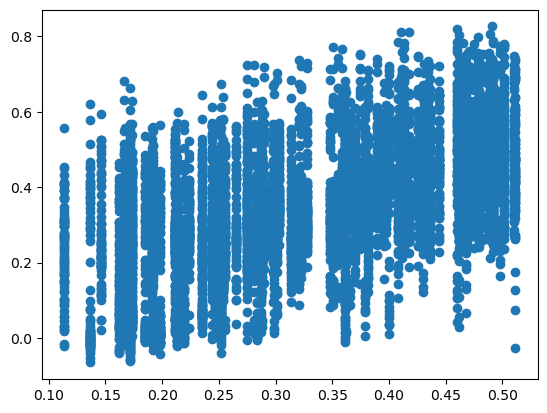

In [ ]:
# plt.scatter(predictions_head2, y_val2_unstd.reshape(81,98))
plt.scatter(predictions_head1, y_val1.reshape(81,98))

## NEW!! read in all models from ablation study loop but calc metrics on unstd data and then dividie by 10k

In [ ]:
# #now test actually removing dif features and calculating MSE
                                         

# def lr_scheduler(epoch, lr):
#     if epoch % 20 == 0 and epoch != 0:
#         lr = lr * 0.1
#     return lr

# lr_scheduler_callback = LearningRateScheduler(lr_scheduler)


# # Input data shape
# timesteps_input = prefire_mo# same as timesteps
# # num_vars = 10 #+1 bc added vcf tree pct as predictor (as well as target)

# # Output data shape
# timesteps_output = 98
# num_targets = 2  # Number of targets to predict (NDVI and LAI) --> change to 3 if using VCF
# lr = 0.01 #before 0329 2nd iter: 0.01



#     # Input data shape
# #     timesteps_input = prefire_mo# same as timesteps
# #     num_vars = 10 #+1 bc added vcf tree pct as predictor (as well as target)

#     # Output data shape
# #     timesteps_output = 98
# #     num_targets = 2  # Number of targets to predict (NDVI and LAI) --> change to 3 if using VCF

# #     units = 150

# feat_names = use_these_bands
# #['slope', 'chili', 'elevation', 'aspect',  'mtpi','precip', 'temp', 'ndvi_before','lai_before', 'severity',"vcf_before"]

# # # for i in range(1):#(10):
# # for keep_these in range(10):
# #     indices_to_del = [0,1,2,3,4,5,6,7,8,9]
# #     indices_to_del.remove(keep_these)
# # for idx in [0]:
# for numUnits in [150]:#, 100, 50, 20]:
# #     print(time.time())
#     # indices_to_keep = [5,6,7,8,9,10], [1,2,3,4,5,6], [0,1,2,3,4,5,6, 9], 
#     #                         [0,1,2,3,4,5,6,7, 9], [0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]
#     #                         [7,8], [7,8,6], [5,6,7,8], [7,8,10]
    
#     # indices_to_del_list = [[0, 1, 2, 3, 4], [0, 7, 8, 9, 10], [7, 8, 10], [8, 10], 
#     #                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
#     #                    [0, 1, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 4, 5, 6, 7, 8, 9, 10], 
#     #                    [0, 1, 2, 3, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 6, 7, 8, 9, 10], 
#     #                    [0, 1, 2, 3, 4, 5, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 8, 9, 10], 
#     #                    [0, 1, 2, 3, 4, 5, 6, 7, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 10], 
#     #                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 9, 10],
#     #                    [0, 1, 2, 3, 4, 5, 9, 10], [0, 1, 2, 3, 4, 9, 10], 
#     #                    [0, 1, 2, 3, 4, 5, 6, 9]]
#     indices_to_del_list = [[0,1,2,3,4,5,6,9,10],[0,1,2,3,4,5,6,9],
#                            [0, 1, 2, 3, 4], [0, 1, 2, 3, 4, 9], [0, 7, 8, 9, 10], [7, 8, 10], 
#                            [0,1,2,3,4,5,6,10],[0,1,2,3,4,10], []] 
#     indices_to_del_list = [[]]
#     indices_to_del_list = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]

#     for indices_to_del in indices_to_del_list:
#         #test: 
#         #all variables 
#         #NDVI, temp, slope, precip, lai (8, 7, 0, 6, 9) -> remove (1,2,3,4,5)
#         #NDVI, temp, slope, lai (8,7,0,9) -> remove (1,2,3,4,5,6)
#         #NDVI, temp, precip, lai (8,7,6,9) -> remove (0,1,2,3,4,5)
#         # NDVI, temp, lai (8,7,9) -> remove (0,1,2,3,4,5,6)
#         #NDVI, temp (8,7)
#         #NDVI, lai (8,9)
        
#         #build model without each variable 
#         num_vars = 11-len(indices_to_del)#2#1#9
#         output_model_name_tag = [feat_names[j] for j in range(11) if j not in indices_to_del]
#         print(output_model_name_tag)
#         output_model_name_tag = '_'.join(output_model_name_tag) + '_units'+str(numUnits) +'_3lstmlayers'+'_lr{}'.format(lr)
#         print(output_model_name_tag)
        
#         #feat_names = ['slope' (0), 'chili' (1), 'elevation' (2), 'aspect' (3),
#                         #'severity' (4), 'mtpi' (5),
#     #                     'precip' (6), 'temp' (7), 'ndvi_before'(8),'lai_before'(9)]
        
#         #remove variable i from X_train
#         num_samples = X_train.shape[0]
#     #     X_train_removed = X_train[:,:,i].reshape(num_samples,timesteps_input, 1)#np.delete(X_train, i, axis=2)
#     #     num_samples = X_test.shape[0]
#     #     X_test_removed = X_test[:,:,i].reshape(num_samples,timesteps_input, 1)#np.delete(X_test, i, axis=2)
#     #     num_samples = X_val.shape[0]
#     #     X_val_removed = X_val[:,:,i].reshape(num_samples,timesteps_input, 1)#np.delete(X_val, i, axis=2)
#     #     indices_to_del = [0,1,2,3,4,5,6,9] #keep: temp + ndvi_before
#         X_train_removed = np.delete(X_train, indices_to_del, axis=2)
#         X_test_removed = np.delete(X_test, indices_to_del, axis=2)
#         X_val_removed = np.delete(X_val, indices_to_del, axis=2)
#         print(X_train_removed.shape[2], 'is features', '({})'.format(num_vars))



#         units = numUnits#100
#         # Create the multi-head model
#         multihead_model_small = tf.keras.model.load(model_path) #Model(inputs=input_layer_v2, outputs=(head1_v2,head2_v2))#concatenated_output_v2)

#         # Compile the model with appropriate loss functions and optimizer
#         # multihead_model.compile(loss=['mean_squared_error','mean_squared_error','mean_squared_error'], optimizer='adam')

#         # Check the model summary
#         #multihead_model_small.summary()

#         ##########
        
        
#         # Make predictions on the test set########################
#         predictions_head1, predictions_head2 = multihead_model_small.predict(X_test_removed)
#         print(predictions_head1.shape, y_test1.shape)
#         ## NEW unstd y_test and val before looking at metrics 

#         y_test1_unstd = y_test1*std_val_ndvi+mean_value_ndvi
#         y_test2_unstd = y_test2*std_val_lai+mean_value_lai

#         y_val1_unstd = y_val1*std_val_ndvi+mean_value_ndvi
#         y_val2_unstd = y_val2*std_val_lai+mean_value_lai

#         # Calculate RMSE for each head
#         rmse_head1 = sqrt(mean_squared_error(y_test1.reshape(111,98), predictions_head1))
#         print(rmse_head1,'is test rmse head 1')

#         rmse_head2 = sqrt(mean_squared_error(y_test2.reshape(111,98), predictions_head2))
#         print(rmse_head2,'is test rmse head 2')

#         store_mse[output_model_name_tag] = [rmse_head1, rmse_head2]
        
#         ##add validation rmses too########################
#         predictions_head1, predictions_head2 = multihead_model_small.predict(X_val_removed)
#     #     print(predictions_head1.shape, y_test1.shape)
#         # Calculate RMSE for each head
#         rmse_head1 = sqrt(mean_squared_error(y_val1.reshape(81,98), predictions_head1))
#         print(rmse_head1,'is val rmse head 1')

#         rmse_head2 = sqrt(mean_squared_error(y_val2.reshape(81,98), predictions_head2))
#         print(rmse_head2,'is val rmse head 2')

#         store_mse[output_model_name_tag].append(rmse_head1)
#         store_mse[output_model_name_tag].append(rmse_head2)
        
#         print(store_mse[output_model_name_tag])
#         ########################

#         multihead_model_small.save(save_path)
#         # save history: Convert the history.history dict to a JSON file
#         with open('model_hist_{}.json'.format(output_model_name_tag), 'w') as f:
#             json.dump(multihead_model_small_history.history, f)





In [ ]:
os.getcwd()

'/Users/clairesimpson/Desktop/CU/LSTM_Project/Output_Data/Data_2024_05_06'

In [ ]:
len(list(store_mse.keys()))


29

In [ ]:
len(list(store_mse.keys()))
# store_mse2 = store_mse.copy()
store_mse

{'slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units150_3lstmlayers_lr0.01': [0.10025079167006003,
  0.27713068770798616,
  0.0985323022563499,
  0.25797049882975226],
 'slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units100_3lstmlayers_lr0.01': [0.11847657153942376,
  0.3653045398791187,
  0.09542798092953411,
  0.2500897830601924],
 'slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units50_3lstmlayers_lr0.01': [0.11945633340084612,
  0.4036300540865928,
  0.09566201121997696,
  0.24798342232378823],
 'slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units20_3lstmlayers_lr0.01': [0.12923746866837124,
  0.40467566038703795,
  0.1024921449059567,
  0.28231599098917903],
 'slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units150_4lstmlayers_lr0.01': [0.096704

In [ ]:
store_mse_copy1= store_mse.copy()

In [ ]:
store_mse_cp

{'precip_temp_ndvi_before_lai_before_severity_units150_3lstmlayers': [0.5376354715740916,
  0.14082936331761792,
  0.47903157428828125,
  0.1396579123303762],
 'chili_elevation_aspect_mtpi_precip_temp_units150_3lstmlayers': [0.7600829351427988,
  0.23021612318233725,
  0.7046554308549465,
  0.27261303198060655],
 'slope_chili_elevation_aspect_mtpi_precip_temp_severity_units150_3lstmlayers': [0.8032367525700328,
  0.27094086561778985,
  0.7139347427795804,
  0.19666340466453774],
 'slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_severity_units150_3lstmlayers': [0.7281944422055485,
  0.25067325100826393,
  0.651182347588662,
  0.192770475252291],
 'slope_units150_3lstmlayers': [0.8212021122980688,
  0.26753552831129723,
  0.7704659284066684,
  0.2209545148658887],
 'chili_units150_3lstmlayers': [0.8431486399205143,
  0.2527780371003466,
  0.7693807928723742,
  0.21131560399262397],
 'elevation_units150_3lstmlayers': [0.8546397045526216,
  0.2570959108166335,
  0.761185049572192

In [ ]:
#create data frame
rnd = 4

df_ablation = pd.DataFrame(data={
    'Variables':[', '.join([x.capitalize() if (x != 'ndvi' and x!='lai' and x!='chili' and x!= 'mtpi' and x!='vcf') else x.upper() for x in n.split('_')[:-3] ]).replace(', Before','').replace('Tree','') for n in list(store_mse.keys())],
    'Test RMSE for NDVI':[round(v[0], rnd) for v in list(store_mse.values())],
    'Test RMSE for LAI': [round(v[1], rnd) for v in store_mse.values()],
    'Validation RMSE for NDVI': [round(v[2], rnd) for v in store_mse.values()],
    'Validation RMSE for LAI': [round(v[3], rnd) for v in store_mse.values()],
    'Number of Units': [n.split('_')[-3].replace('units','') for n in list(store_mse.keys())],
    'Number of Layers': [n.split('_')[-2].replace('lstmlayers','') for n in list(store_mse.keys())],
    'Learning Rate (start, with Scheduler)': [n.split('_')[-1].replace('lr','') for n in list(store_mse.keys())],
    'Filename': store_mse.keys()
  
}                         
)

#export dataframe to CSV -> this will be ablation study table in report 
df_ablation.to_csv("AblationTable_v1_cp.csv")

In [ ]:
#create data frame
rnd = 4

df_ablation = pd.DataFrame(data={
    'Variables':[', '.join([x.capitalize() if (x != 'ndvi' and x!='lai' and x!='chili' and x!= 'mtpi' and x!='vcf') else x.upper() for x in n.split('_')[:-3] ]).replace(', Before','').replace('Tree','') for n in list(store_mse.keys())],
    #'Test RMSE for NDVI':[round(v[0], rnd) for v in list(store_mse.values())],
    #'Test RMSE for LAI': [round(v[1], rnd) for v in store_mse.values()],
    'Validation RMSE for NDVI': [round(v[2], rnd) for v in store_mse.values()],
    'Validation RMSE for LAI': [round(v[3], rnd) for v in store_mse.values()],
    'Number of Units': [n.split('_')[-3].replace('units','') for n in list(store_mse.keys())],
    'Number of Layers': [n.split('_')[-2].replace('lstmlayers','') for n in list(store_mse.keys())],
   # 'Learning Rate (start, with Scheduler)': [n.split('_')[-1].replace('lr','') for n in list(store_mse.keys())],
    'Filename': store_mse.keys()
  
}                         
)

#export dataframe to CSV -> this will be ablation study table in report 
df_ablation.to_csv("TableX.csv")

In [ ]:
store_mse

{'slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units16_3lstmlayers_lr0.01': [0.11148486552934705,
  0.3583456174201605,
  0.1099589315739742,
  0.2986348075824006],
 'slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units32_3lstmlayers_lr0.01': [0.12665913485783267,
  0.39651923508970155,
  0.11182266102509916,
  0.29394977522766064],
 'slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units64_3lstmlayers_lr0.01': [0.08869984706114323,
  0.2618311839819198,
  0.09501947117883659,
  0.24334132076490445],
 'slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units128_3lstmlayers_lr0.01': [0.09727527675905455,
  0.26029571724965583,
  0.09026609393002906,
  0.2362175190632316],
 'slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units256_3lstmlayers_lr0.01': [0.0907568

In [ ]:
feat_names

['slope',
 'chili',
 'elevation',
 'aspect',
 'mtpi',
 'precip',
 'temp',
 'ndvi_before',
 'lai_before',
 'severity',
 'vcf_tree_before']

In [ ]:
os.getcwd()

'/Users/clairesimpson/Desktop/CU/LSTM_Project/Output_Data/Data_2024_05_32'

## Train final model with both train/val

In [ ]:
#now test actually removing dif features and calculating MSE
                                         

# def lr_scheduler(epoch, lr):
#     if epoch % 20 == 0 and epoch != 0:
#         lr = lr * 0.1
#     return lr

# lr_scheduler_callback = LearningRateScheduler(lr_scheduler)


# Input data shape
timesteps_input = prefire_mo# same as timesteps
# num_vars = 10 #+1 bc added vcf tree pct as predictor (as well as target)

# Output data shape
timesteps_output = 98
num_targets = 2  # Number of targets to predict (NDVI and LAI) --> change to 3 if using VCF
lr = 0.01 #before 0329 2nd iter: 0.01



    # Input data shape
#     timesteps_input = prefire_mo# same as timesteps
#     num_vars = 10 #+1 bc added vcf tree pct as predictor (as well as target)

    # Output data shape
#     timesteps_output = 98
#     num_targets = 2  # Number of targets to predict (NDVI and LAI) --> change to 3 if using VCF

#     units = 150

feat_names = use_these_bands
#['slope', 'chili', 'elevation', 'aspect',  'mtpi','precip', 'temp', 'ndvi_before','lai_before', 'severity',"vcf_before"]

# # for i in range(1):#(10):
# for keep_these in range(10):
#     indices_to_del = [0,1,2,3,4,5,6,7,8,9]
#     indices_to_del.remove(keep_these)
# for idx in [0]:
for numUnits in [128]:#, 100, 50, 20]:
#     print(time.time())
    # indices_to_keep = [5,6,7,8,9,10], [1,2,3,4,5,6], [0,1,2,3,4,5,6, 9], 
    #                         [0,1,2,3,4,5,6,7, 9], [0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]
    #                         [7,8], [7,8,6], [5,6,7,8], [7,8,10]
    
    # indices_to_del_list = [[0, 1, 2, 3, 4], [0, 7, 8, 9, 10], [7, 8, 10], [8, 10], 
    #                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
    #                    [0, 1, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 4, 5, 6, 7, 8, 9, 10], 
    #                    [0, 1, 2, 3, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 6, 7, 8, 9, 10], 
    #                    [0, 1, 2, 3, 4, 5, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 8, 9, 10], 
    #                    [0, 1, 2, 3, 4, 5, 6, 7, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 10], 
    #                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 9, 10],
    #                    [0, 1, 2, 3, 4, 5, 9, 10], [0, 1, 2, 3, 4, 9, 10], 
    #                    [0, 1, 2, 3, 4, 5, 6, 9]]
    indices_to_del_list = [[0,1,2,3,4,5,6,9,10],[0,1,2,3,4,5,6,9],
                           [0, 1, 2, 3, 4], [0, 1, 2, 3, 4, 9], [0, 7, 8, 9, 10], [7, 8, 10], 
                           [0,1,2,3,4,5,6,10],[0,1,2,3,4,10], []] 
    indices_to_del_list = [[]]
    # indices_to_del_list = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]
    for indices_to_del in indices_to_del_list:
        
        #build model without each variable 
        num_vars = 11-len(indices_to_del)#2#1#9
        print(len(indices_to_del))
        print(num_vars, 'is num vars')
        output_model_name_tag = [feat_names[j] for j in range(11) if j not in indices_to_del]
        print(output_model_name_tag)
        output_model_name_tag = 'FINAL'+'_'.join(output_model_name_tag) + '_units'+str(numUnits) +'_3lstmlayers'+'_lr{}'.format(lr)
        print(output_model_name_tag)
        
        #feat_names = ['slope' (0), 'chili' (1), 'elevation' (2), 'aspect' (3),
                        #'severity' (4), 'mtpi' (5),
    #                     'precip' (6), 'temp' (7), 'ndvi_before'(8),'lai_before'(9)]
        
        #remove variable i from X_train
        comboX_train = np.concatenate((X_train, X_val), axis = 0)
        comboy_train1 = np.concatenate((y_train1, y_val1), axis=0)
        comboy_train2 = np.concatenate((y_train2, y_val2), axis=0)
        print(X_train.shape,X_val.shape,comboX_train.shape, comboy_train1.shape)
        num_samples = comboX_train.shape[0]
    #     X_train_removed = X_train[:,:,i].reshape(num_samples,timesteps_input, 1)#np.delete(X_train, i, axis=2)
        num_samples = X_test.shape[0]
        X_test_removed = X_test#[:,:,:].reshape(num_samples,timesteps_input, 11)#np.delete(X_test, i, axis=2)
        print(X_test.shape)
    #     num_samples = X_val.shape[0]
    #     X_val_removed = X_val[:,:,i].reshape(num_samples,timesteps_input, 1)#np.delete(X_val, i, axis=2)
    #     indices_to_del = [0,1,2,3,4,5,6,9] #keep: temp + ndvi_before
        

        units = numUnits#100

        # Define the input layer
        input_layer_v2 = Input(shape=(timesteps_input, num_vars))

        # LSTM layers shared across both heads
        lstm_layer1_v2 = LSTM(units, activation='tanh', return_sequences=True)(input_layer_v2)
        bn_layer1 = BatchNormalization()(lstm_layer1_v2)
        dropout_layer1_v2 = Dropout(0.1)(bn_layer1)

        lstm_layer2_v2 = LSTM(units, activation='tanh', return_sequences=True)(dropout_layer1_v2)
        bn_layer2 = BatchNormalization()(lstm_layer2_v2)
        dropout_layer2_v2 = Dropout(0.1)(bn_layer2)

        # lstm_layer3_v2 = LSTM(units, activation='tanh', return_sequences=True)(dropout_layer2_v2)
        # dropout_layer3_v2 = Dropout(0.1)(lstm_layer3_v2)

        lstm_layer4_v2 = LSTM(units, activation='tanh')(dropout_layer2_v2)

        # Separate output heads for each target
        head1_v2 = Dense(timesteps_output)(lstm_layer4_v2)  # Output for NDVI
        head2_v2 = Dense(timesteps_output)(lstm_layer4_v2)  # Output for LAI
        # head3 = Dense(timesteps_output)(lstm_layer4)  # Output for VCF Tree Pct

        # Create the multi-head model
        multihead_model_small = Model(inputs=input_layer_v2, outputs=(head1_v2,head2_v2))#concatenated_output_v2)

        # Compile the model with appropriate loss functions and optimizer
        # multihead_model.compile(loss=['mean_squared_error','mean_squared_error','mean_squared_error'], optimizer='adam')

        # Check the model summary
        #multihead_model_small.summary()

        ##########
        
        adam = keras.optimizers.Adam(learning_rate=lr)
        early_stops = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50,
                                    restore_best_weights=True)
        save_path = "LSTM_BN_{}.keras".format( output_model_name_tag)#"LSTM_NDVI_LAI_featNdviTemp.keras" #9var_var{}".format(i),
        # checkpoints =tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
        #                                                 monitor='val_loss',#mode='max',
        #                                                 save_best_only=True,
        #                                                 save_freq='epoch', period=10)


        multihead_model_small.compile(loss = 'mse', optimizer =adam, metrics=['mse'])
        multihead_model_small_history = multihead_model_small.fit(comboX_train, 
                                                                (comboy_train1, comboy_train2), 
                                                                verbose=True, epochs = 70,
                                                                #callbacks=[early_stops,checkpoints],
                                                                batch_size = 256)

        
        # Make predictions on the test set########################
         # Make predictions on the test set########################
        predictions_head1, predictions_head2 = multihead_model_small.predict(X_test_removed)

        # y_test1_unstd = y_test1*std_val_ndvi+mean_value_ndvi
        # y_test2_unstd = y_test2*std_val_lai+mean_value_lai


        predictions_head1 = predictions_head1*std_val_ndvi+ mean_value_ndvi
        predictions_head2 = predictions_head2*std_val_lai+ mean_value_lai


        print(predictions_head1.shape, y_test1.shape)
        # Calculate RMSE for each head
        rmse_head1 = sqrt(mean_squared_error(y_test1.reshape(111,98), predictions_head1))
        print(rmse_head1,'is test rmse head 1')

        rmse_head2 = sqrt(mean_squared_error(y_test2.reshape(111,98), predictions_head2))
        print(rmse_head2,'is test rmse head 2')

        #store_mse[output_model_name_tag] = [rmse_head1, rmse_head2]
        

        ########################

        multihead_model_small.save(save_path)
        # save history: Convert the history.history dict to a JSON file
        with open('model_hist_{}.json'.format(output_model_name_tag), 'w') as f:
            json.dump(multihead_model_small_history.history, f)



0
11 is num vars
['slope', 'chili', 'elevation', 'aspect', 'mtpi', 'precip', 'temp', 'ndvi_before', 'lai_before', 'severity', 'vcf_tree_before']
FINALslope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units128_3lstmlayers_lr0.01
(806, 132, 11) (81, 132, 11) (887, 132, 11) (887, 98, 1)
(111, 132, 11)
Epoch 1/70
4/4 [==============================] - 5s 794ms/step - loss: 1.7269 - dense_70_loss: 0.9568 - dense_71_loss: 0.7701 - dense_70_mse: 0.9568 - dense_71_mse: 0.7701
Epoch 2/70
4/4 [==============================] - 3s 778ms/step - loss: 0.8636 - dense_70_loss: 0.4645 - dense_71_loss: 0.3991 - dense_70_mse: 0.4645 - dense_71_mse: 0.3991
Epoch 3/70
4/4 [==============================] - 3s 763ms/step - loss: 0.6919 - dense_70_loss: 0.3866 - dense_71_loss: 0.3053 - dense_70_mse: 0.3866 - dense_71_mse: 0.3053
Epoch 4/70
4/4 [==============================] - 3s 769ms/step - loss: 0.5599 - dense_70_loss: 0.3138 - dense_71_loss: 0.2461 - dense_70

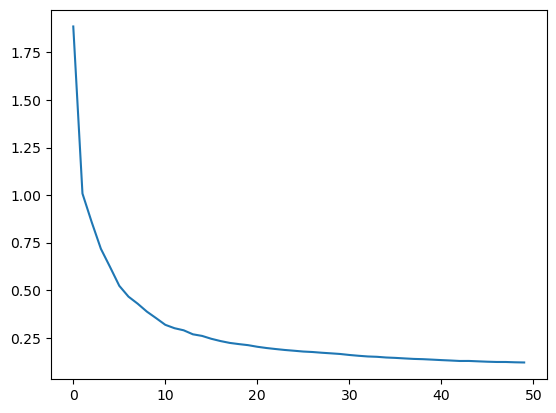

In [ ]:
plt.plot(multihead_model_small_history.history["loss"])

In [ ]:
# Make predictions on the test set########################
num_samples = X_test.shape[0]
if True:
        X_test_removed = X_test#[:,:,i].reshape(num_samples,timesteps_input, 1)#np.delete(X_test, i, axis=2)

        predictions_head1, predictions_head2 = multihead_model_small.predict(X_test_removed)
        print(predictions_head1.shape, y_test1.shape)
        # Calculate RMSE for each head
        rmse_head1 = sqrt(mean_squared_error(y_test1.reshape(111,98), predictions_head1))
        print(rmse_head1,'is test rmse head 1')

        rmse_head2 = sqrt(mean_squared_error(y_test2.reshape(111,98), predictions_head2))
        print(rmse_head2,'is test rmse head 2')

        store_mse[output_model_name_tag] = [rmse_head1, rmse_head2]
        
        ##add validation rmses too########################
        predictions_head1, predictions_head2 = multihead_model_small.predict(X_val)#_removed)
    #     print(predictions_head1.shape, y_test1.shape)
        # Calculate RMSE for each head
        rmse_head1 = sqrt(mean_squared_error(y_val1.reshape(81,98), predictions_head1))
        print(rmse_head1,'is val rmse head 1')

        rmse_head2 = sqrt(mean_squared_error(y_val2.reshape(81,98), predictions_head2))
        print(rmse_head2,'is val rmse head 2')

        store_mse[output_model_name_tag].append(rmse_head1)
        store_mse[output_model_name_tag].append(rmse_head2)
        
        print(store_mse[output_model_name_tag])
        ########################

        multihead_model_small.save(save_path)
        # save history: Convert the history.history dict to a JSON file
        with open('model_hist_{}.json'.format(output_model_name_tag), 'w') as f:
            json.dump(multihead_model_small_history.history, f)

4/4 [==============================] - 0s 21ms/step
(111, 98) (111, 98, 1)
0.7586268507637353 is test rmse head 1
0.792470913832831 is test rmse head 2


NameError: name 'store_mse' is not defined

In [ ]:
for k,v in store_mse.items():
    print(k, ':',v)

slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units16_3lstmlayers_lr0.01 : [0.11148486552934705, 0.3583456174201605, 0.1099589315739742, 0.2986348075824006]
slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units32_3lstmlayers_lr0.01 : [0.12665913485783267, 0.39651923508970155, 0.11182266102509916, 0.29394977522766064]
slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units64_3lstmlayers_lr0.01 : [0.08869984706114323, 0.2618311839819198, 0.09501947117883659, 0.24334132076490445]
slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units128_3lstmlayers_lr0.01 : [0.09727527675905455, 0.26029571724965583, 0.09026609393002906, 0.2362175190632316]
slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units256_3lstmlayers_lr0.01 : [0.09075689377692395, 0.24248701825351632, 0.097

In [ ]:
## compare RMSE values of baseline model2 (below - trained on 12/9/23) to these:

# 0.5484911263462591 is rmse head 1
# 0.15299820050378418 is rmse head 2

baseline_rmse = [0.5484911263462591, 0.15299820050378418]

for k,v in store_mse_9feat.items():
    print(feat_names[k]+ ':',round(v[0],5),',', round(v[1],5))
    print('\tdif from baseline:',round(v[0] - baseline_rmse[0], 5),',', round(v[1] - baseline_rmse[1], 5),'\n')

In [ ]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Reshape

# units = 100

# # Define the input layer
# input_layer = Input(shape=(timesteps_input, num_vars))

# # LSTM layers shared across both heads
# lstm_layer1 = LSTM(units, activation='tanh', return_sequences=True)(input_layer)
# dropout_layer1 = Dropout(0.1)(lstm_layer1)

# lstm_layer2 = LSTM(units, activation='tanh', return_sequences=True)(dropout_layer1)
# dropout_layer2 = Dropout(0.1)(lstm_layer2)

# lstm_layer3 = LSTM(units, activation='tanh', return_sequences=True)(dropout_layer2)
# dropout_layer3 = Dropout(0.1)(lstm_layer3)

# lstm_layer4 = LSTM(units, activation='tanh')(dropout_layer3)

# # Separate output heads for each target
# head1 = Dense(timesteps_output)(lstm_layer4)  # Output for NDVI
# head2 = Dense(timesteps_output)(lstm_layer4)  # Output for LAI
# # head3 = Dense(timesteps_output)(lstm_layer4)  # Output for VCF Tree Pct


# # Reshape the outputs to match the desired output shape (None, 98, 1)
# head1 = Reshape((timesteps_output, 1))(head1)
# head2 = Reshape((timesteps_output, 1))(head2)
# # head3 = Reshape((timesteps_output, 1))(head3)

# # Concatenate the output heads along the last axis to get shape (None, 98, 2)
# concatenated_output = tf.keras.layers.concatenate([head1, head2], axis=-1) #, head3

# # Create the multi-head model
# multihead_model = Model(inputs=input_layer, outputs=concatenated_output)

# # Compile the model with appropriate loss functions and optimizer
# # multihead_model.compile(loss=['mean_squared_error','mean_squared_error','mean_squared_error'], optimizer='adam')

# # Check the model summary
# multihead_model.summary()


## LOAD MODEL

In [ ]:
os.getcwd()
os.chdir('/Users/clairesimpson/Desktop/CU/LSTM_Project/Output_Data/Data_2024_01_25_useThis')#Use_These_13123')
# os.chdir('/Users/clairesimpson/Desktop/CU/LSTM_Project/Output_Data/Use_These_13123')
# os.chdir('/Users/clairesimpson/Desktop/CU/LSTM_Project/Output_Data/Data_2024_01_23')#Use_These_13123')
os.chdir('/Users/clairesimpson/Desktop/CU/LSTM_Project/Output_Data/Data_2024_03_28')#Use_These_13123')
os.chdir('/Users/clairesimpson/Desktop/CU/LSTM_Project/Output_Data/Data_2024_04_01')
os.chdir('/Users/clairesimpson/Desktop/CU/LSTM_Project/Output_Data/Data_2024_05_32')


In [ ]:
import json
print(os.getcwd())
#test loading a model and history
# test_model2 = tf.keras.models.load_model("../Data_2023_12_09/LSTM_NDVI_LAI_model2.h5")
# model2 = tf.keras.models.load_model("LSTM_slope_chili_elevation_aspect_severity_mtpi_precip_temp_ndvi_before_lai_before_units100.keras") #this is in: ../Data_2024_01_23/
# model2 = tf.keras.models.load_model("LSTM_slope_chili_elevation_aspect_severity_mtpi_precip_temp_ndvi_before_lai_before_units100_3lstmlayers.keras")
#prev: Data_2024_01_25 in this folder is model
model2_name = "LSTM_slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units128_3lstmlayers_lr0.01.keras"
# model2_name = "LSTM_FINALslope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units50_4lstmlayers_lr0.01.keras"
#LSTM_slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units50_4lstmlayers_lr0_005.keras"
# model2_name = "LSTM_FINAL_trainVal_FINALslope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units128_4lstmlayers_lr0.01.keras"
# model2_name = "LSTM_BN_FINALslope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units128_3lstmlayers_lr0.01.keras"


model2 = tf.keras.models.load_model(model2_name)
# model2_hist = "model_hist_slope_chili_elevation_aspect_severity_mtpi_precip_temp_ndvi_before_lai_before_units100_3lstmlayers.json"
model2_hist = model2_name.replace('LSTM','model_hist').replace('.keras','.json')
# model2_hist = "model_hist_BN_FINALslope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units128_3lstmlayers_lr0.01.json"

#"model_hist_slope_chili_

# elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units50_4lstmlayers_lr0_005.json"
#load history
with open(model2_hist, 'r') as f:
    model2_history = json.load(f)

/Users/clairesimpson/Desktop/CU/LSTM_Project/Output_Data/Data_2024_05_32


In [ ]:
model2.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 132, 11)]    0           []                               
                                                                                                  
 lstm_18 (LSTM)                 (None, 132, 128)     71680       ['input_7[0][0]']                
                                                                                                  
 dropout_12 (Dropout)           (None, 132, 128)     0           ['lstm_18[0][0]']                
                                                                                                  
 lstm_19 (LSTM)                 (None, 132, 128)     131584      ['dropout_12[0][0]']             
                                                                                            

#### Plot Model Loss

Best Epoch (Model restored from this eopch) 49 Early Stopping Kicked in at Epoch 99


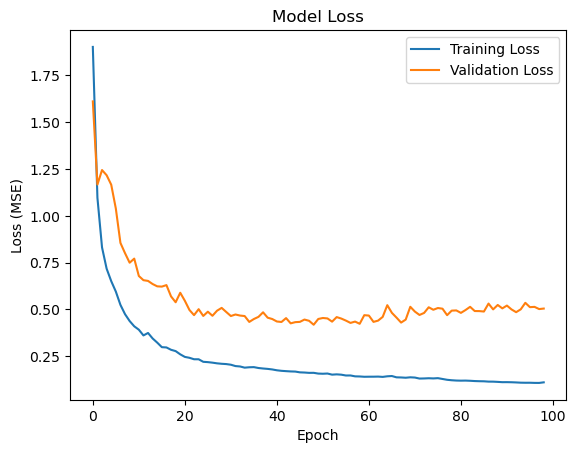

In [ ]:

# multihead model loss
# Plot loss and validation loss
# model2_history.keys()
# plt.plot(model2_history['loss'])

plt.plot(model2_history['loss'], label="Training Loss")
plt.plot(model2_history['val_loss'], label ="Validation Loss")
# plt.plot(model2_history.history['dense_26_loss'], label ="Head 1 Train Loss")
# plt.plot(model2_history.history['dense_27_loss'], label ="Head 2 Train Loss")
# plt.plot(model2_history.history['val_dense_26_loss'], label ="Head 1 Val. Loss")
# plt.plot(model2_history.history['val_dense_27_loss'], label ="Head 2 Val. Loss")

print("Best Epoch (Model restored from this eopch)", np.argmin(model2_history['val_loss'])+1,
      "Early Stopping Kicked in at Epoch", np.argmin(model2_history['val_loss'])+1 + 50)


plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend( loc='upper right')
plt.savefig("ModelLoss_LSTM2_v1.png", dpi=300)
# plt.show()

In [ ]:
std_val_lai, std_val_ndvi, mean_value_lai, mean_value_ndvi

(0.5817712578132047,
 0.17920622027822677,
 0.8027389277389284,
 0.4523571086171898)

### Get Model R2

In [ ]:
#get R2
round_to =3
from sklearn.metrics import r2_score

print(y_test1.shape)

# Make predictions on the test set
predictions_head1, predictions_head2 = model2.predict(X_test)

#undo std 
# y_test1 = y_test1*std_val_ndvi+mean_value_ndvi
# y_test2 = unstd_minmax(y_test2)*std_val_lai+mean_value_lai


predictions_head1 = predictions_head1*std_val_ndvi+ mean_value_ndvi
predictions_head2 = predictions_head2*std_val_lai+ mean_value_lai
# predictions_head1 = predictions_head1[:,1:]
# predictions_head2 = predictions_head2[:,1:]


print(predictions_head1.shape)

# Calculate R2 for each head
r2_head1 = round(r2_score(y_test1.reshape(111, 98).flatten(), predictions_head1.flatten()), round_to)
print(r2_head1, 'is R2 for head 1 NDVI')

r2_head2 = round(r2_score(y_test2.reshape(111, 98).flatten(), predictions_head2.flatten()), round_to)
print(r2_head2, 'is R2 for head 2 LAI')



(111, 98, 1)


2024-06-05 12:01:41.869949: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 1s 53ms/step
(111, 98)
0.547 is R2 for head 1 NDVI
0.66 is R2 for head 2 LAI
